# 1: Data Quality - Relatório de Falhas

In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, sum as spark_sum, count, avg, percentile_approx,
    when, isnan, isnull, lit, asc, desc
)
from pyspark.sql.types import StructType, StructField, LongType, StringType, DecimalType
import matplotlib.pyplot as plt
import time
from typing import Dict, Tuple

# ==================== CONFIGURAÇÃO INICIAL - SESSION SPARK ====================
# Objetivo: Inicializar a sessão Spark com otimizações de performance para processamento
# de grande volume de dados (1M+ registros de pedidos, 10k+ clientes)
#
# Configurações aplicadas:
# - spark.sql.adaptive.enabled=true: Habilita otimizações adaptativas de execução,
#   permitindo que o Spark ajuste o plano de execução dinamicamente
# - spark.sql.adaptive.coalescePartitions.enabled=true: Reduz partições desnecessárias
#   após agrupamentos, economizando memória e reduzindo overhead de I/O
# - spark.serializer=KryoSerializer: Usa serialização Kryo em vez de Pickle, 10-100x mais rápida
# - spark.sql.shuffle.partitions=500: Define partições ideais para shuffle operations,
#   balanceando memória e paralelismo (padrão 200, aumentado para dataset grande)
# - spark.default.parallelism=200: Define paralelismo padrão para operações distribuídas

construtor_sessao_spark: SparkSession.Builder = SparkSession.builder \
    .appName("AnalisePedidosClientes") \
    .master("local[*]")

construtor_sessao_spark = construtor_sessao_spark.config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrationRequired", "false") \
    .config("spark.sql.shuffle.partitions", "500") \
    .config("spark.default.parallelism", "200")

sessao_spark: SparkSession = construtor_sessao_spark.getOrCreate()
print("Bibliotecas importadas com sucesso")
print("Sessão Spark criada com otimizações de performance")

Bibliotecas importadas com sucesso
Sessão Spark criada com otimizações de performance


In [2]:
# ==================== 0.1 CARREGAMENTO DE DADOS - CLIENTES ====================
# Objetivo: Carregar dados de clientes do arquivo JSON com validação de schema
#
# Justificativa de schema:
# - LongType para 'id': Garante que identificadores únicos não sofram truncamento
#   e permite integração com 64-bit systems
# - StringType para 'name': Flexível para nomes de qualquer tamanho
#
# Estratégias de otimização:
# - repartition(4): Para 10k registros, 4 partições equilibra processamento local
#   com overhead de shuffle (regra: 1 partição por GB de dados)
# - cache(): Manter dados em memória pois será usado em múltiplos joins (lines 286+, 292+)

esquema_clientes: StructType = StructType([
    StructField("id", LongType(), True),
    StructField("name", StringType(), True)
])

caminho_dados_clientes: str = "clients/data.json"
dataframe_clientes: DataFrame = sessao_spark.read.json(
    caminho_dados_clientes,
    schema=esquema_clientes,
    multiLine=False
)
dataframe_clientes: DataFrame = dataframe_clientes.repartition(4).cache()

quantidade_clientes_carregados: int = dataframe_clientes.count()
print(f"{quantidade_clientes_carregados:,} clientes carregados do arquivo JSON")
dataframe_clientes.show(truncate=False)

10,001 clientes carregados do arquivo JSON
+----+-----------------+
|id  |name             |
+----+-----------------+
|5518|Thiago Araújo    |
|7978|Flávia Mesquita  |
|1198|Zuleica Souza    |
|509 |Julia Martins    |
|2919|Valentina Correia|
|2807|Helena Rodrigues |
|4586|Nina Queiroz     |
|9117|Sofia Castro     |
|8726|Daniel Moreira   |
|5993|Ursula Barreto   |
|1816|Ricardo Barbosa  |
|1192|Tamires Lacerda  |
|3869|Wesley Rangel    |
|6080|Heloísa Brito    |
|1245|Xavier Peixoto   |
|345 |Xavier Peixoto   |
|7026|Daniel Moreira   |
|5978|Flávia Mesquita  |
|7434|Leonardo Barros  |
|7896|Ximena Costa     |
+----+-----------------+
only showing top 20 rows


In [3]:
# ==================== 0.2 CARREGAMENTO DE DADOS - PEDIDOS ====================
# Objetivo: Carregar dados de pedidos com esquema tipado para validação em leitura
#
# Justificativa de schema:
# - LongType para 'id' e 'client_id': Identificadores únicos com integridade garantida
# - DecimalType(5,2): Armazena valores monetários com precisão fixa (máximo 999.99)
#   evitando problemas de arredondamento em floating point (ex: 0.1 + 0.2 ≠ 0.3)
#
# Estratégias de otimização:
# - repartition(8): Para 1M registros, 8 partições (1M/8 = 125k por partição) garante
#   distribuição uniforme sem subutilização de cores
# - cache(): Será usado em joins múltiplos e agrupamentos, justificando cache()

esquema_pedidos: StructType = StructType([
    StructField("id", LongType(), True),
    StructField("client_id", LongType(), True),
    StructField("value", DecimalType(5, 2), True)
])

caminho_dados_pedidos: str = "pedidos/data.json"
dataframe_pedidos: DataFrame = sessao_spark.read.json(
    caminho_dados_pedidos,
    schema=esquema_pedidos,
    multiLine=False
)
dataframe_pedidos: DataFrame = dataframe_pedidos.repartition(8).cache()

quantidade_pedidos_carregados: int = dataframe_pedidos.count()
print(f"{quantidade_pedidos_carregados:,} pedidos carregados do arquivo JSON")
dataframe_pedidos.show(truncate=False)

1,100,000 pedidos carregados do arquivo JSON
+--------+---------+-----+
|id      |client_id|value|
+--------+---------+-----+
|67720549|123456   |62.61|
|4632947 |123456   |62.63|
|65628493|123456   |65.43|
|31631301|123456   |15.57|
|5869880 |123456   |39.91|
|13086257|123456   |70.67|
|40911976|123456   |25.50|
|45886935|123456   |22.38|
|75324385|123456   |72.35|
|21322647|123456   |24.47|
|82770598|123456   |34.53|
|95640675|123456   |66.97|
|62116724|123456   |29.70|
|50528984|123456   |35.07|
|35399735|123456   |55.06|
|76541497|123456   |7.33 |
|72406017|123456   |10.92|
|65826360|123456   |38.88|
|97248462|123456   |61.66|
|14385901|123456   |93.52|
+--------+---------+-----+
only showing top 20 rows


In [4]:
# ==================== 0.3 BENCHMARK - OTIMIZAÇÃO DE PARTIÇÕES ====================
# Objetivo: Encontrar configuração ótima de partições para shuffle operations neste hardware
#
# Metodologia:
# - Testa combinações de spark.sql.shuffle.partitions e spark.default.parallelism
# - Executa 5 vezes cada combinação para calcular média
# - Mede tempo de execução de agregação típica (groupBy + sum)
# - Identifica melhor balance entre memória, I/O e tempo de processamento
#
# Parâmetros testados:
# - shuffle_partitions: Controla paralelismo em operações de shuffle (groupBy, join)
# - parallelism: Define threads paralelas para operações RDD
# - Range [100,200,500]: Contempla configs conservadora, balanceada e agressiva

def medir_tempo_configuracao_particoes(
    quantidade_particoes_shuffle: int,
    paralelismo_padrao: int
) -> float:
    """
    Executa operação agregada com configuração específica de partições e retorna tempo.
    """
    sessao_spark.conf.set("spark.sql.shuffle.partitions", str(quantidade_particoes_shuffle))
    sessao_spark.conf.set("spark.default.parallelism", str(paralelismo_padrao))

    tempos_execucao = []
    for i in range(5):  # repete 5 vezes
        print(f"\nExecução {i+1}/5 - shuffle={quantidade_particoes_shuffle}, paralelism={paralelismo_padrao}...")
        momento_inicio: float = time.time()

        resultado_agregacao: DataFrame = dataframe_pedidos.groupBy("client_id").agg(
            spark_sum("value").alias("valor_total")
        )
        resultado_agregacao.count()  # Força materialização

        momento_fim: float = time.time()
        tempo_decorrido: float = momento_fim - momento_inicio
        print(f"Tempo de execução: {tempo_decorrido:.2f} segundos")
        tempos_execucao.append(tempo_decorrido)

    # retorna média das 5 execuções
    media_tempo = sum(tempos_execucao) / len(tempos_execucao)
    print(f"\nMédia de tempo (5 execuções): {media_tempo:.2f} segundos")
    return media_tempo

# Valores para testar (grid search)
valores_shuffle: list[int] = [100, 200, 500]
valores_paralelismo: list[int] = [100, 200, 500]

resultados_benchmark: Dict[Tuple[int, int], float] = {}
for quantidade_shuffle in valores_shuffle:
    for quantidade_paralelismo in valores_paralelismo:
        resultados_benchmark[(quantidade_shuffle, quantidade_paralelismo)] = \
            medir_tempo_configuracao_particoes(quantidade_shuffle, quantidade_paralelismo)

# Identifica melhor combinação
configuracao_otima: Tuple[int, int] = min(resultados_benchmark, key=resultados_benchmark.get)
tempo_otimo: float = resultados_benchmark[configuracao_otima]

print("\n" + "="*60)
print("RESULTADO DO BENCHMARK")
print("="*60)
print(f"Melhor configuração: shuffle={configuracao_otima[0]}, paralelism={configuracao_otima[1]}")
print(f"Tempo médio (5 execuções): {tempo_otimo:.2f} segundos")
print("="*60)


Execução 1/5 - shuffle=100, paralelism=100...
Tempo de execução: 2.27 segundos

Execução 2/5 - shuffle=100, paralelism=100...
Tempo de execução: 2.68 segundos

Execução 3/5 - shuffle=100, paralelism=100...
Tempo de execução: 1.93 segundos

Execução 4/5 - shuffle=100, paralelism=100...
Tempo de execução: 1.12 segundos

Execução 5/5 - shuffle=100, paralelism=100...
Tempo de execução: 0.74 segundos

Média de tempo (5 execuções): 1.75 segundos

Execução 1/5 - shuffle=100, paralelism=200...
Tempo de execução: 0.74 segundos

Execução 2/5 - shuffle=100, paralelism=200...
Tempo de execução: 0.82 segundos

Execução 3/5 - shuffle=100, paralelism=200...
Tempo de execução: 0.82 segundos

Execução 4/5 - shuffle=100, paralelism=200...
Tempo de execução: 0.69 segundos

Execução 5/5 - shuffle=100, paralelism=200...
Tempo de execução: 0.65 segundos

Média de tempo (5 execuções): 0.75 segundos

Execução 1/5 - shuffle=100, paralelism=500...
Tempo de execução: 0.69 segundos

Execução 2/5 - shuffle=100, p

In [5]:
# ==================== 1.0 VALIDAÇÃO DE CLIENTES ====================
# Objetivo: Identificar inconsistências em dados de clientes antes de usar em join
#
# Justificativa: Detectar problemas antes de join reduz erro silencioso. Clientes com
# ID nulo ou duplicado podem causar duplicação de registros na agregação final.

print("\n" + "="*60)
print("VALIDAÇÃO DE QUALIDADE - DADOS DE CLIENTES")
print("="*60)

# ---- 1.1 Validação: Valores nulos em 'id' ----
dataframe_clientes_id_nulo: DataFrame = dataframe_clientes.filter(
    isnull(col("id"))
).withColumn(
    "campo_problema", lit("id")
).withColumn(
    "descricao_erro", lit("ID nulo ou ausente")
).select("id", "campo_problema", "descricao_erro")

# ---- 1.2 Validação: Valores nulos em 'name' ----
dataframe_clientes_nome_nulo: DataFrame = dataframe_clientes.filter(
    isnull(col("name"))
).withColumn(
    "campo_problema", lit("name")
).withColumn(
    "descricao_erro", lit("Nome nulo ou ausente")
).select("id", "campo_problema", "descricao_erro")

# ---- 1.3 Consolidar falhas por valores nulos ----
dataframe_clientes_falhas_nulos: DataFrame = (
    dataframe_clientes_id_nulo.union(dataframe_clientes_nome_nulo)
    .orderBy(asc("id"))
)
quantidade_clientes_falhas_nulos: int = dataframe_clientes_falhas_nulos.count()
print(f"\nFalhas por valores nulos em clientes: {quantidade_clientes_falhas_nulos}")
dataframe_clientes_falhas_nulos.show(truncate=False)

# ---- 1.4 Validação: IDs duplicados em clientes ----
# Técnica: groupBy + having para identificar IDs que aparecem mais de uma vez
dataframe_clientes_ids_duplicados: DataFrame = (
    dataframe_clientes.groupBy("id")
    .agg(count("*").alias("quantidade_ocorrencias"))
    .filter(col("quantidade_ocorrencias") > 1)
    .orderBy(asc("id"))
)

quantidade_ids_distintos_duplicados: int = dataframe_clientes_ids_duplicados.count()
print(f"\nQuantidade de IDs distintos com duplicatas: {quantidade_ids_distintos_duplicados}")

# ---- 1.5 DataFrame com detalhes dos IDs duplicados ----
dataframe_clientes_falhas_ids_duplicados: DataFrame = (
    dataframe_clientes.join(
        dataframe_clientes_ids_duplicados.select("id"),
        on="id",
        how="inner"
    )
    .withColumn("campo_problema", lit("id"))
    .withColumn("descricao_erro", lit("ID duplicado em tabela de clientes"))
    .select("id", "campo_problema", "descricao_erro")
    .distinct()
    .orderBy(asc("id"))
)
quantidade_total_ids_duplicados: int = dataframe_clientes_falhas_ids_duplicados.count()
print(f"Quantidade total de linhas com IDs duplicados: {quantidade_total_ids_duplicados}")
dataframe_clientes_falhas_ids_duplicados.show(truncate=False)

# ---- 1.6 Validação: Nomes duplicados em clientes ----
# Nota: Nomes duplicados não são necessariamente erro, mas indicam possível problema de qualidade
dataframe_clientes_nomes_duplicados: DataFrame = (
    dataframe_clientes.groupBy("name")
    .agg(count("*").alias("quantidade_ocorrencias"))
    .filter(col("quantidade_ocorrencias") > 1)
    .orderBy(asc("name"))
)

quantidade_nomes_distintos_duplicados: int = dataframe_clientes_nomes_duplicados.count()
print(f"\nQuantidade de nomes distintos com duplicatas: {quantidade_nomes_distintos_duplicados}")
dataframe_clientes_nomes_duplicados.show(truncate=False)

# ---- 1.7 DataFrame com detalhes dos nomes duplicados ----
dataframe_clientes_falhas_nomes_duplicados: DataFrame = (
    dataframe_clientes.join(
        dataframe_clientes_nomes_duplicados.select("name"),
        on="name",
        how="inner"
    )
    .withColumn("campo_problema", lit("name"))
    .withColumn("descricao_erro", lit("Nome duplicado em tabela de clientes"))
    .select("id", "name", "campo_problema", "descricao_erro")
    .orderBy(asc("name"))
)
print(f"\nQuantidade de registros com nomes duplicados: {dataframe_clientes_falhas_nomes_duplicados.count()}")
dataframe_clientes_falhas_nomes_duplicados.show(truncate=False)

# ---- 1.8 Relatório consolidado de falhas em clientes ----
dataframe_clientes_relatorio_falhas: DataFrame = (
    dataframe_clientes_falhas_nulos.union(dataframe_clientes_falhas_ids_duplicados)
    .cache()
)

total_falhas_clientes: int = dataframe_clientes_relatorio_falhas.count()
print(f"\n{'='*60}")
print(f"RESUMO: Total de falhas em clientes: {total_falhas_clientes}")
print(f"{'='*60}")
dataframe_clientes_relatorio_falhas.show(truncate=False)


VALIDAÇÃO DE QUALIDADE - DADOS DE CLIENTES

Falhas por valores nulos em clientes: 0
+---+--------------+--------------+
|id |campo_problema|descricao_erro|
+---+--------------+--------------+
+---+--------------+--------------+


Quantidade de IDs distintos com duplicatas: 0
Quantidade total de linhas com IDs duplicados: 0
+---+--------------+--------------+
|id |campo_problema|descricao_erro|
+---+--------------+--------------+
+---+--------------+--------------+


Quantidade de nomes distintos com duplicatas: 100
+---------------+----------------------+
|name           |quantidade_ocorrencias|
+---------------+----------------------+
|Alberto Vargas |100                   |
|Alice Fernandes|100                   |
|Amanda Rocha   |100                   |
|Ana Silva      |100                   |
|André Lima     |100                   |
|Beatriz Amaral |100                   |
|Bernardo Pinto |100                   |
|Breno Soares   |100                   |
|Bruno Costa    |100       

In [6]:
# ==================== 1.1 VALIDAÇÃO DE PEDIDOS - VALORES NULOS ====================
# Objetivo: Detectar registros de pedidos incompletos (campos nulos)
#
# Justificativa: Pedidos com valor nulo não podem ser agregados. Client_id nulo
# impossibilita vinculação a cliente. ID nulo viola primary key.
#
# Estratégia: Usar isnull() para campos numéricos/string e isnan() para Decimal
# (NaN pode ocorrer em operações aritméticas antes de leitura)

print("\n" + "="*60)
print("VALIDAÇÃO DE QUALIDADE - DADOS DE PEDIDOS")
print("="*60)

# ---- 1.1.1 Valores nulos em 'id' (primary key) ----
dataframe_pedidos_id_nulo: DataFrame = dataframe_pedidos.filter(
    isnull(col("id"))
).withColumn(
    "campo_problema", lit("id")
).withColumn(
    "descricao_erro", lit("ID nulo - viola primary key")
).select("id", "campo_problema", "descricao_erro")

# ---- 1.1.2 Valores nulos em 'client_id' (foreign key) ----
dataframe_pedidos_client_id_nulo: DataFrame = dataframe_pedidos.filter(
    isnull(col("client_id"))
).withColumn(
    "campo_problema", lit("client_id")
).withColumn(
    "descricao_erro", lit("Client_ID nulo - não permite join com clientes")
).select("id", "campo_problema", "descricao_erro")

# ---- 1.1.3 Valores nulos ou NaN em 'value' (monetário) ----
dataframe_pedidos_valor_nulo: DataFrame = dataframe_pedidos.filter(
    isnull(col("value")) | isnan(col("value"))
).withColumn(
    "campo_problema", lit("value")
).withColumn(
    "descricao_erro", lit("Valor nulo/NaN")
).select("id", "campo_problema", "descricao_erro")

# ---- 1.1.4 Consolidar falhas por nulos ----
dataframe_pedidos_falhas_nulos: DataFrame = (
    dataframe_pedidos_id_nulo
    .union(dataframe_pedidos_client_id_nulo)
    .union(dataframe_pedidos_valor_nulo)
    .orderBy(asc("id"))
)
quantidade_falhas_nulos: int = dataframe_pedidos_falhas_nulos.count()
print(f"\nFalhas por valores nulos em pedidos: {quantidade_falhas_nulos}")
dataframe_pedidos_falhas_nulos.show(truncate=False)


VALIDAÇÃO DE QUALIDADE - DADOS DE PEDIDOS

Falhas por valores nulos em pedidos: 50000
+-----+--------------+--------------+
|id   |campo_problema|descricao_erro|
+-----+--------------+--------------+
|1534 |value         |Valor nulo/NaN|
|3502 |value         |Valor nulo/NaN|
|3679 |value         |Valor nulo/NaN|
|4322 |value         |Valor nulo/NaN|
|4724 |value         |Valor nulo/NaN|
|5774 |value         |Valor nulo/NaN|
|6322 |value         |Valor nulo/NaN|
|6622 |value         |Valor nulo/NaN|
|6884 |value         |Valor nulo/NaN|
|7116 |value         |Valor nulo/NaN|
|8597 |value         |Valor nulo/NaN|
|9322 |value         |Valor nulo/NaN|
|10786|value         |Valor nulo/NaN|
|14240|value         |Valor nulo/NaN|
|14804|value         |Valor nulo/NaN|
|16194|value         |Valor nulo/NaN|
|16383|value         |Valor nulo/NaN|
|16929|value         |Valor nulo/NaN|
|18559|value         |Valor nulo/NaN|
|18623|value         |Valor nulo/NaN|
+-----+--------------+--------------+
o

In [7]:
# ==================== 1.2 VALIDAÇÃO DE PEDIDOS - IDS DUPLICADOS ====================
# Objetivo: Detectar se há múltiplos pedidos com mesmo ID (violação de chave primária)
#
# Justificativa: ID deve ser único. Duplicatas indicam erro no processo ETL/ingestion.
# Manter todos os registros duplicados pode distorcer agregações (soma 2x, contagem 2x)
#
# Estratégia: groupBy(id) + having(count > 1) identifica os IDs únicos problemáticos
# Depois fazer inner join para recuperar todas as linhas desses IDs

# ---- 1.2.1 Identificar IDs distintos com duplicatas ----
dataframe_pedidos_ids_duplicados: DataFrame = (
    dataframe_pedidos.groupBy("id")
    .agg(count("*").alias("quantidade_ocorrencias"))
    .filter(col("quantidade_ocorrencias") > 1)
    .orderBy(asc("id"))
)

quantidade_ids_distintos_duplicados_pedidos: int = dataframe_pedidos_ids_duplicados.count()
print(f"\nQuantidade de IDs distintos duplicados: {quantidade_ids_distintos_duplicados_pedidos}")

# ---- 1.2.2 Recuperar todas as linhas com IDs duplicados ----
dataframe_pedidos_falhas_ids_duplicados: DataFrame = (
    dataframe_pedidos.join(
        dataframe_pedidos_ids_duplicados.select("id"),
        on="id",
        how="inner"
    )
    .withColumn("campo_problema", lit("id"))
    .withColumn("descricao_erro", lit("ID duplicado - viola chave primária"))
    .select("id", "campo_problema", "descricao_erro")
)
quantidade_total_linhas_ids_duplicados: int = dataframe_pedidos_falhas_ids_duplicados.count()
print(f"Quantidade total de linhas com IDs duplicados: {quantidade_total_linhas_ids_duplicados}\n")

# Mostrar resumo
print("IDs Distintos com Duplicatas:")
dataframe_pedidos_ids_duplicados.show(truncate=False)

print("\nTodas as linhas com IDs duplicados:")
dataframe_pedidos_falhas_ids_duplicados_distinct: DataFrame = (
    dataframe_pedidos_falhas_ids_duplicados
    .select("id", "campo_problema", "descricao_erro")
    .distinct()
    .orderBy(asc("id"))
)
dataframe_pedidos_falhas_ids_duplicados_distinct.show(truncate=False)


Quantidade de IDs distintos duplicados: 54491
Quantidade total de linhas com IDs duplicados: 159507

IDs Distintos com Duplicatas:
+-----+----------------------+
|id   |quantidade_ocorrencias|
+-----+----------------------+
|1534 |3                     |
|3443 |2                     |
|3502 |3                     |
|3679 |3                     |
|4322 |3                     |
|4724 |3                     |
|5774 |3                     |
|6322 |3                     |
|6622 |3                     |
|6884 |3                     |
|7116 |3                     |
|8597 |3                     |
|9322 |3                     |
|10786|3                     |
|14240|3                     |
|14804|3                     |
|16194|3                     |
|16383|3                     |
|16929|3                     |
|18559|3                     |
+-----+----------------------+
only showing top 20 rows

Todas as linhas com IDs duplicados:
+-----+--------------+-----------------------------------+
|id

In [8]:
# ==================== 1.3 VALIDAÇÃO DE PEDIDOS - VIOLAÇÃO DE FK ====================
# Objetivo: Identificar pedidos com client_id que não existe em tabela de clientes
#
# Justificativa: FK violação impossibilita agregação cliente/pedido (join resultará nulo).
# Causa comum: cliente deletado mas pedidos permanem, ou ID typo no ingestion.
#
# Estratégia: left_anti join retorna apenas linhas de pedidos que NÃO têm match em clientes
# left_anti é mais eficiente que left + filter(isnull()) para esse caso

dataframe_pedidos_fk_violacao: DataFrame = dataframe_pedidos.join(
    dataframe_clientes,
    dataframe_pedidos.client_id == dataframe_clientes.id,
    "left_anti"
).withColumn(
    "campo_problema", lit("client_id")
).withColumn(
    "descricao_erro", lit("Client_ID não existe em tabela de clientes (FK violation)")
).select("id", "campo_problema", "descricao_erro")

quantidade_fk_violacoes: int = dataframe_pedidos_fk_violacao.count()
print(f"FK violações: {quantidade_fk_violacoes}")

FK violações: 0


In [9]:
# ==================== 1.4 VALIDAÇÃO DE PEDIDOS - VALORES INVÁLIDOS ====================
# Objetivo: Detectar valores monetários negativos (logicamente impossíveis em e-commerce)
#
# Justificativa: Pedidos com value < 0 distorcem agregações (média, soma, percentis).
# Pode indicar erro de digitação, conversão, ou dados de crédito/reembolso incorretamente
# categorizados como pedidos regulares.
#
# Estratégia: Usar col("value") < 0 para comparação com Decimal preservando precisão

dataframe_pedidos_valor_invalido: DataFrame = dataframe_pedidos.filter(
    col("value") < 0
).withColumn(
    "campo_problema", lit("value")
).withColumn(
    "descricao_erro", lit("Valor negativo - inválido para pedido de venda")
).select("id", "campo_problema", "descricao_erro")

quantidade_registros_valor_negativo: int = dataframe_pedidos_valor_invalido.count()
quantidade_ids_distintos_valor_negativo: int = (
    dataframe_pedidos_valor_invalido.select("id").distinct().count()
)
print(f"\nQuantidade total de registros com valor negativo: {quantidade_registros_valor_negativo}")
print(f"Quantidade de IDs distintos com valor negativo: {quantidade_ids_distintos_valor_negativo}")


Quantidade total de registros com valor negativo: 50000
Quantidade de IDs distintos com valor negativo: 49985


In [10]:
# ==================== 1.5 RELATÓRIO CONSOLIDADO DE FALHAS ====================
# Objetivo: Unificar todas as validações em um único dataframe para análise integrada

# ---- 1.5.1 Consolidar todas as falhas identificadas ----
dataframe_relatorio_falhas: DataFrame = (
    dataframe_pedidos_falhas_nulos
    .union(dataframe_pedidos_falhas_ids_duplicados_distinct)
    .union(dataframe_pedidos_fk_violacao)
    .union(dataframe_pedidos_valor_invalido)
    .orderBy(asc("id"))
    .cache()
)
dataframe_relatorio_falhas.show(truncate=False)

+----+--------------+----------------------------------------------+
|id  |campo_problema|descricao_erro                                |
+----+--------------+----------------------------------------------+
|1534|value         |Valor nulo/NaN                                |
|1534|id            |ID duplicado - viola chave primária           |
|1534|value         |Valor negativo - inválido para pedido de venda|
|3443|id            |ID duplicado - viola chave primária           |
|3502|value         |Valor nulo/NaN                                |
|3502|id            |ID duplicado - viola chave primária           |
|3502|value         |Valor negativo - inválido para pedido de venda|
|3679|value         |Valor nulo/NaN                                |
|3679|id            |ID duplicado - viola chave primária           |
|3679|value         |Valor negativo - inválido para pedido de venda|
|4322|value         |Valor nulo/NaN                                |
|4322|id            |ID duplicado 


GERANDO GRÁFICO DE DISTRIBUIÇÃO DE FALHAS


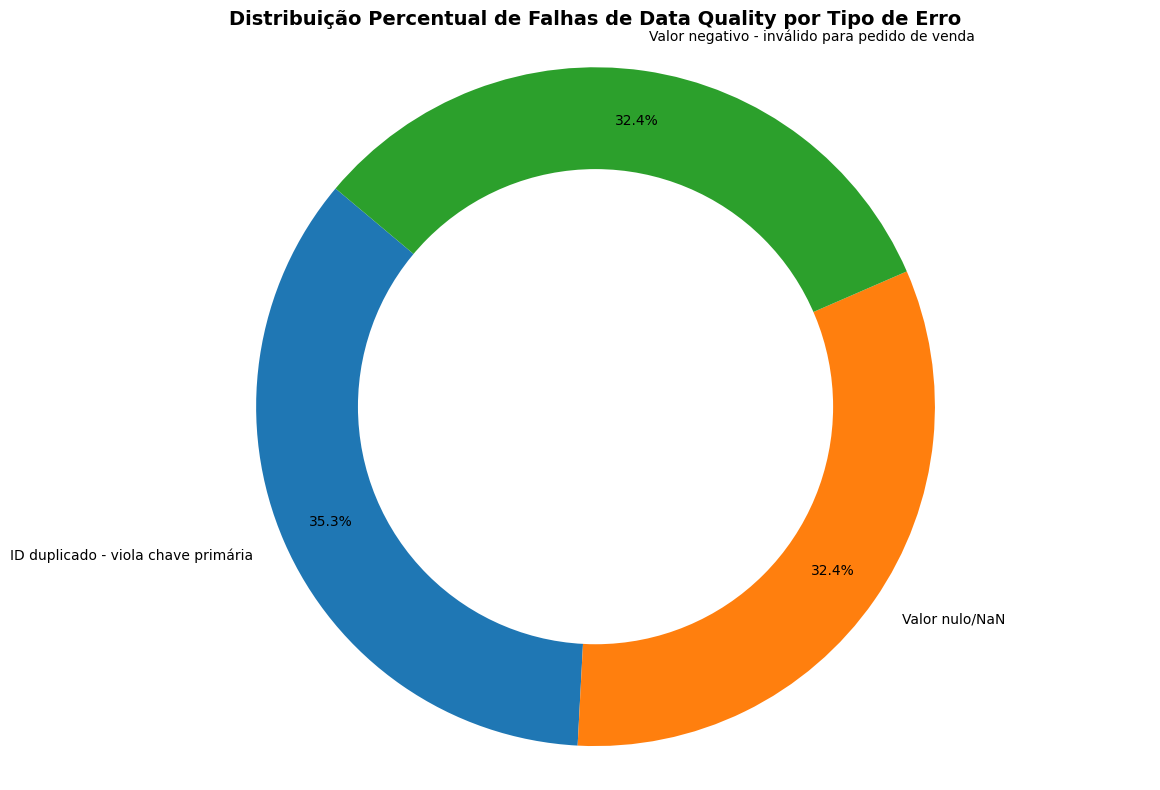

In [11]:
# ==================== 1.6 VISUALIZAÇÃO - DISTRIBUIÇÃO DE ERROS ====================
# Objetivo: Criar visualização da distribuição percentual de tipos de erro
#
# Justificativa: Gráfico de rosca (donut) é ideal para mostrar composição relativa
# de categorias. Permite identificar rapidamente qual tipo de erro predomina.
#
# Escolhas técnicas:
# - groupBy("descricao_erro") + count(): Agrupa erros iguais, contando ocorrências
# - Gráfico de rosca (vs pizza): Mais legível com muitas categorias, destaca total no centro

print(f"\n{'='*60}")
print(f"GERANDO GRÁFICO DE DISTRIBUIÇÃO DE FALHAS")
print(f"{'='*60}")

# ---- 1.6.1 Agregar falhas por tipo de erro ----
dataframe_contagem_erros_por_tipo: DataFrame = (
    dataframe_relatorio_falhas.groupBy("descricao_erro")
    .agg(count("*").alias("quantidade_ocorrencias"))
)

# ---- 1.6.2 Materializar dados para plotting (collect) ----
dados_para_plot: list = dataframe_contagem_erros_por_tipo.collect()

labels_erros: list[str] = [linha["descricao_erro"] for linha in dados_para_plot]
tamanhos_barras: list[int] = [linha["quantidade_ocorrencias"] for linha in dados_para_plot]

# ---- 1.6.3 Criar gráfico de rosca ----
figura: plt.Figure = plt.figure(figsize=(12, 8))
plt.pie(
    tamanhos_barras,
    labels=labels_erros,
    autopct='%1.1f%%',  # Formato percentual com 1 casa decimal
    startangle=140,      # Inicia em 140° para melhor layout
    pctdistance=0.85     # Distância dos percentuais do centro
)

# Criar círculo branco no centro para transformar em gráfico de rosca
circulo_centro: plt.Circle = plt.Circle((0, 0), 0.70, fc='white')
eixo_atual: plt.Axes = plt.gcf().gca()
eixo_atual.add_artist(circulo_centro)

plt.title("Distribuição Percentual de Falhas de Data Quality por Tipo de Erro", fontsize=14, fontweight='bold')
plt.axis('equal')  # Garante proporção 1:1 (círculo, não elipse)
plt.tight_layout()
plt.show()

In [12]:
# ==================== 1.7 ANÁLISE DE IMPACTO - IDS ÚNICOS COM FALHAS ====================
# Objetivo: Quantificar quantos IDs únicos de pedidos têm pelo menos uma falha
#
# Justificativa: Visualizar todas as falhas juntas permite:
# 1. Entender distribuição de tipos de erro
# 2. Quantificar impacto total na qualidade de dados
# 3. Identificar padrões (ex: múltiplas falhas no mesmo pedido)

total_falhas_consolidadas: int = dataframe_relatorio_falhas.count()

# ---- 1.5.2 Mapeamento de tipos de erro para categorias Data Quality ----
# Objetivo: Classificar erros em categorias padrão de data quality para análise estruturada
dicionario_categorias_erro: Dict[str, str] = {
    "ID nulo - viola primary key": "COMPLETENESS",
    "Client_ID nulo - não permite join com clientes": "COMPLETENESS",
    "Valor nulo/NaN - não pode ser agregado": "COMPLETENESS",
    "ID duplicado - viola chave primária": "UNIQUENESS",
    "Client_ID não existe em tabela de clientes (FK violation)": "REFERENTIAL_INTEGRITY",
    "Valor negativo - inválido para pedido de venda": "VALIDITY"
}

# ---- 1.5.3 Criar DataFrame com categorias de erro ----
dataframe_relatorio_falhas_com_categorias: DataFrame = (
    dataframe_relatorio_falhas
    .withColumn(
        "categoria_qualidade",
        when(
            col("descricao_erro") == "ID nulo - viola primary key",
            lit("COMPLETENESS")
        ).when(
            col("descricao_erro") == "Client_ID nulo - não permite join com clientes",
            lit("COMPLETENESS")
        ).when(
            col("descricao_erro") == "Valor nulo/NaN",
            lit("COMPLETENESS")
        ).when(
            col("descricao_erro") == "ID duplicado - viola chave primária",
            lit("UNIQUENESS")
        ).when(
            col("descricao_erro") == "Client_ID não existe em tabela de clientes (FK violation)",
            lit("REFERENTIAL_INTEGRITY")
        ).when(
            col("descricao_erro") == "Valor negativo - inválido para pedido de venda",
            lit("VALIDITY")
        ).otherwise(
            lit("UNKNOWN")
        )
    )
)

print(f"\n{'='*60}")
print(f"CLASSIFICAÇÃO DE ERROS POR CATEGORIA DATA QUALITY")
print(f"{'='*60}")
print("\nCategorizações:")
print("  • COMPLETENESS: Campos obrigatórios com valores nulos")
print("  • UNIQUENESS: Violação de chaves primárias (IDs duplicados)")
print("  • REFERENTIAL_INTEGRITY: Violação de chaves estrangeiras (FK inválida)")
print("  • VALIDITY: Valores logicamente inválidos para o domínio (negativo)")
print()
dataframe_relatorio_falhas_com_categorias.show(truncate=False)

ids_unicos_com_falhas: DataFrame = dataframe_relatorio_falhas.select("id").distinct()
quantidade_ids_unicos_com_falhas: int = ids_unicos_com_falhas.count()

print(f"\n{'='*60}")
print(f"RELATÓRIO CONSOLIDADO DE FALHAS")
print(f"{'='*60}")
print(f"Total de falhas identificadas: {total_falhas_consolidadas:,}")
print(f"Total de IDs únicos de pedidos com pelo menos uma falha: {quantidade_ids_unicos_com_falhas:,}")


CLASSIFICAÇÃO DE ERROS POR CATEGORIA DATA QUALITY

Categorizações:
  • COMPLETENESS: Campos obrigatórios com valores nulos
  • UNIQUENESS: Violação de chaves primárias (IDs duplicados)
  • REFERENTIAL_INTEGRITY: Violação de chaves estrangeiras (FK inválida)
  • VALIDITY: Valores logicamente inválidos para o domínio (negativo)

+----+--------------+----------------------------------------------+-------------------+
|id  |campo_problema|descricao_erro                                |categoria_qualidade|
+----+--------------+----------------------------------------------+-------------------+
|1534|value         |Valor nulo/NaN                                |COMPLETENESS       |
|1534|id            |ID duplicado - viola chave primária           |UNIQUENESS         |
|1534|value         |Valor negativo - inválido para pedido de venda|VALIDITY           |
|3443|id            |ID duplicado - viola chave primária           |UNIQUENESS         |
|3502|value         |Valor nulo/NaN            

In [13]:
# ==================== 1.8 CÁLCULO DO IMPACTO - TAXA DE FALHAS ====================
# Objetivo: Quantificar percentual de dados com problemas em relação ao total
#
# Justificativa: Métrica essencial para stakeholders entenderem severidade do problema

quantidade_total_pedidos_carregados: int = dataframe_pedidos.count()
quantidade_pedidos_impactados: int = quantidade_ids_unicos_com_falhas
percentual_impacto: float = (quantidade_pedidos_impactados / quantidade_total_pedidos_carregados) * 100

print(f"\n{'='*60}")
print(f"MÉTRICAS DE IMPACTO DE QUALIDADE")
print(f"{'='*60}")
print(f"Total de pedidos carregados: {quantidade_total_pedidos_carregados:,}")
print(f"Pedidos com pelo menos uma falha: {quantidade_pedidos_impactados:,}")
print(f"Percentual de impacto: {percentual_impacto:.2f}%")
print(f"{'='*60}")


MÉTRICAS DE IMPACTO DE QUALIDADE
Total de pedidos carregados: 1,100,000
Pedidos com pelo menos uma falha: 54,491
Percentual de impacto: 4.95%


# 2: Agregação de Dados

In [14]:
# ==================== 2.0 FILTRAGEM - APENAS PEDIDOS VÁLIDOS ====================
# Objetivo: Remover pedidos com falhas antes de análises subsequentes
#
# Justificativa: left_anti join é a forma mais eficiente de filtrar. Remove todos
# os pedidos que têm ID na lista de IDs problemáticos. Essencial antes de agregação
# para garantir métricas (média, soma) corretas.
#
# Alternativa não usada: filter + isnull() seria ineficiente pois testaríamos cada
# linha individualmente em vez de fazer join distribuído.

dataframe_pedidos_validos: DataFrame = dataframe_pedidos.join(
    ids_unicos_com_falhas,
    dataframe_pedidos.id == ids_unicos_com_falhas.id,
    "left_anti"
).orderBy(asc("client_id"))

quantidade_pedidos_validos: int = dataframe_pedidos_validos.count()
print(f"\n{'='*60}")
print(f"FILTRAGEM CONCLUÍDA")
print(f"{'='*60}")
print(f"Total de pedidos válidos para análise: {quantidade_pedidos_validos:,}")
dataframe_pedidos_validos.show(truncate=False)


FILTRAGEM CONCLUÍDA
Total de pedidos válidos para análise: 940,493
+--------+---------+-----+
|id      |client_id|value|
+--------+---------+-----+
|83358716|0        |35.80|
|61406078|0        |98.87|
|40126872|0        |53.42|
|94917061|0        |71.98|
|26450305|0        |63.59|
|47842025|0        |91.26|
|93990670|0        |40.21|
|63846121|0        |72.78|
|77084155|0        |81.11|
|60905344|0        |40.44|
|60915498|0        |97.63|
|27491246|0        |2.98 |
|45382119|0        |54.58|
|32521217|0        |32.23|
|27079635|0        |90.37|
|2029716 |0        |15.55|
|94723286|0        |71.78|
|71469335|0        |41.17|
|33438149|0        |70.66|
|42956630|0        |97.76|
+--------+---------+-----+
only showing top 20 rows


In [15]:
# ==================== 2.1 AGREGAÇÃO DE DADOS POR CLIENTE ====================
# Objetivo: Calcular métricas consolidadas de pedidos por cliente
#
# Justificativa do join estratégia:
# - aliases("pedidos" e "clientes"): Clareza no código, evita ambiguidade em joins complexos
# - inner join: Garante que apenas clientes com pedidos válidos apareçam no resultado
# - groupBy + count + sum: Agregações distribuídas, Spark otimiza automaticamente
#
# Formatação DecimalType(11,2):
# - Máximo 999.999.999,99 (suficiente para > maioria dos dados monetários)
# - 2 casas decimais: Compatível com padrão monetário (centavos)

print(f"\n{'='*60}")
print(f"AGREGAÇÃO DE DADOS POR CLIENTE")
print(f"{'='*60}")

# ---- 2.1.1 Join pedidos válidos com dados de clientes ----
dataframe_analise_clientes: DataFrame = dataframe_pedidos_validos.alias(
    "pedidos"
).join(
    dataframe_clientes.alias("clientes"),
    col("pedidos.client_id") == col("clientes.id"),
    "inner"
)

# ---- 2.1.2 Agrupamento por cliente com agregações ----
dataframe_agregado_por_cliente: DataFrame = dataframe_analise_clientes.groupBy(
    col("clientes.id"),
    col("clientes.name")
).agg(
    count(col("pedidos.id")).alias("quantidade_pedidos"),
    spark_sum(col("pedidos.value")).alias("valor_total_bruto")
)

# ---- 2.1.3 Seleção e rename final com tipagem ----
dataframe_resultado_agregacao: DataFrame = dataframe_agregado_por_cliente.select(
    col("clientes.id").alias("id_cliente").cast(LongType()),
    col("name").alias("nome_cliente").cast(StringType()),
    col("quantidade_pedidos").cast(LongType()),
    col("valor_total_bruto").cast("decimal(11,2)").alias("valor_total_pedidos")
).orderBy(desc("valor_total_pedidos"))

print("\nAgregação concluída. Clientes ordenados por valor total (decrescente):")
dataframe_resultado_agregacao.show(truncate=False)


AGREGAÇÃO DE DADOS POR CLIENTE

Agregação concluída. Clientes ordenados por valor total (decrescente):
+----------+---------------+------------------+-------------------+
|id_cliente|nome_cliente   |quantidade_pedidos|valor_total_pedidos|
+----------+---------------+------------------+-------------------+
|123456    |Inês Siqueira  |469734            |23698016.90        |
|9047      |Zachary Reis   |61                |4002.08            |
|4494      |Vitor Marques  |68                |3937.06            |
|2695      |Wanda Silva    |61                |3736.53            |
|2756      |Inês Siqueira  |60                |3735.58            |
|8566      |Tereza Leal    |66                |3731.10            |
|6135      |Mariana Melo   |71                |3700.71            |
|5221      |Yasmin Carvalho|65                |3679.35            |
|9266      |Tereza Leal    |67                |3678.17            |
|2379      |Gustavo Pontes |65                |3657.84            |
|8317      |

In [16]:
# ==================== 2.2 VALIDAÇÃO - SOMA TOTAL DE PEDIDOS ====================
# Objetivo: Verificar integridade da agregação comparando somas
#
# Justificativa: Se soma de quantidade_pedidos ≠ contagem de dataframe_pedidos_validos,
# há erro na agregação (possível perda de dados ou duplicação).

soma_total_quantidade_pedidos: int = (
    dataframe_resultado_agregacao.agg(
        spark_sum("quantidade_pedidos").alias("total_quantidade")
    ).collect()[0]["total_quantidade"]
)

print(f"\n{'='*60}")
print(f"VALIDAÇÃO - INTEGRIDADE DA AGREGAÇÃO")
print(f"{'='*60}")
print(f"Total de pedidos válidos originais: {quantidade_pedidos_validos:,}")
print(f"Soma de quantidade_pedidos (agregado): {soma_total_quantidade_pedidos:,}")
print(f"Match: {'SIM' if soma_total_quantidade_pedidos == quantidade_pedidos_validos else 'X NÃO'}")
print(f"{'='*60}")


VALIDAÇÃO - INTEGRIDADE DA AGREGAÇÃO
Total de pedidos válidos originais: 940,493
Soma de quantidade_pedidos (agregado): 940,493
Match: SIM


# 3: Análise Estatística

In [17]:
# ==================== 3.0 ANÁLISE ESTATÍSTICA DE VALORES ====================
# Objetivo: Calcular distribuição estatística de valores totais por cliente
#
# Justificativa de cada métrica:
# - MÉDIA (avg): Valor esperado em caso de distribuição uniforme. Afetada por outliers.
# - MEDIANA (P50): Valor central, representa cliente "típico". Robusta a outliers.
# - PERCENTIL 10: Limite inferior (10% dos clientes têm valor abaixo disso).
#   Identifica clientes de baixo valor (base da pirâmide).
# - PERCENTIL 90: Limite superior (10% dos clientes têm valor acima disso).
#   Identifica "clientes VIP" (topo da pirâmide).
#
# Função percentile_approx vs percentile_cont:
# - percentile_approx: Rápido, aproximado, ideal para grandes datasets (±1% erro aceitável)
# - percentile_cont: Exato, lento em distribuições skewed
# Est sendo usado percentile_approx para performance em 1M+ registros

print(f"\n{'='*60}")
print(f"ANÁLISE ESTATÍSTICA - DISTRIBUIÇÃO DE VALORES")
print(f"{'='*60}\n")

# ---- 3.0.1 Cálculo de média aritmética ----
valor_medio_cliente: float = dataframe_resultado_agregacao.agg(
    avg(col("valor_total_pedidos")).alias("media")
).collect()[0]["media"]

# ---- 3.0.2 Cálculo de mediana (percentil 50) ----
valor_mediano_cliente: float = dataframe_resultado_agregacao.agg(
    percentile_approx(col("valor_total_pedidos"), 0.5).alias("mediana")
).collect()[0]["mediana"]

# ---- 3.0.3 Cálculo de percentil 10 (10% inferiores) ----
valor_percentil_10: float = dataframe_resultado_agregacao.agg(
    percentile_approx(col("valor_total_pedidos"), 0.1).alias("percentil_10")
).collect()[0]["percentil_10"]

# ---- 3.0.4 Cálculo de percentil 90 (10% superiores) ----
valor_percentil_90: float = dataframe_resultado_agregacao.agg(
    percentile_approx(col("valor_total_pedidos"), 0.9).alias("percentil_90")
).collect()[0]["percentil_90"]

# ---- 3.0.5 Exibição formatada dos resultados ----
print("Métrica                          | Valor")
print("-" * 50)
print(f"Média Aritmética                 | R$ {valor_medio_cliente:,.2f}".replace(",", "#").replace(".", ",").replace("#", "."))
print(f"Mediana (P50)                    | R$ {valor_mediano_cliente:,.2f}".replace(",", "#").replace(".", ",").replace("#", "."))
print(f"Percentil 10 (10% inferiores)   | R$ {valor_percentil_10:,.2f}".replace(",", "#").replace(".", ",").replace("#", "."))
print(f"Percentil 90 (10% superiores)   | R$ {valor_percentil_90:,.2f}".replace(",", "#").replace(".", ",").replace("#", "."))
print("-" * 50)
print(f"\nInterpretação:")
print(f"  • 10% dos clientes gastam até R$ {valor_percentil_10:,.2f}")
print(f"  • 50% dos clientes gastam até R$ {valor_mediano_cliente:,.2f}")
print(f"  • 90% dos clientes gastam até R$ {valor_percentil_90:,.2f}")
print(f"{'='*60}")


ANÁLISE ESTATÍSTICA - DISTRIBUIÇÃO DE VALORES

Métrica                          | Valor
--------------------------------------------------
Média Aritmética                 | R$ 4.746,44
Mediana (P50)                    | R$ 2.368,14
Percentil 10 (10% inferiores)   | R$ 1.880,32
Percentil 90 (10% superiores)   | R$ 2.888,44
--------------------------------------------------

Interpretação:
  • 10% dos clientes gastam até R$ 1,880.32
  • 50% dos clientes gastam até R$ 2,368.14
  • 90% dos clientes gastam até R$ 2,888.44


# 4: Filtragem - Acima da Média

In [18]:
# ==================== 4.0 FILTRAGEM - CLIENTES ACIMA DA MÉDIA ====================
# Objetivo: Identificar clientes cuja receita total exceede a média de todos os clientes
#
# Justificativa:
# - Estratégia de segmentação simples mas eficaz
# - Identifica "high-value customers" que geram maior receita
# - Caso de uso: Marketing pode focar em reter esses clientes, aumentar ticket médio
#
# SQL equivalente:
#   SELECT * FROM clientes_agregados WHERE valor_total_pedidos > media

print(f"\n{'='*60}")
print(f"CLIENTES ACIMA DA MÉDIA")
print(f"{'='*60}\n")

dataframe_clientes_acima_media: DataFrame = dataframe_resultado_agregacao.filter(
    col("valor_total_pedidos") > valor_medio_cliente
).orderBy(desc("valor_total_pedidos"))

quantidade_clientes_acima_media: int = dataframe_clientes_acima_media.count()
percentual_clientes_acima_media: float = (
    quantidade_clientes_acima_media / dataframe_resultado_agregacao.count()
) * 100

print(f"Quantidade de clientes acima da média: {quantidade_clientes_acima_media:,}")
print(f"Percentual do total: {percentual_clientes_acima_media:.2f}%")
print(f"Limite mínimo (média): R$ {valor_medio_cliente:,.2f}")
print(f"\nClientes com valor_total_pedidos > R$ {valor_medio_cliente:,.2f}:")
dataframe_clientes_acima_media.show(truncate=False)


CLIENTES ACIMA DA MÉDIA

Quantidade de clientes acima da média: 1
Percentual do total: 0.01%
Limite mínimo (média): R$ 4,746.44

Clientes com valor_total_pedidos > R$ 4,746.44:
+----------+-------------+------------------+-------------------+
|id_cliente|nome_cliente |quantidade_pedidos|valor_total_pedidos|
+----------+-------------+------------------+-------------------+
|123456    |Inês Siqueira|469734            |23698016.90        |
+----------+-------------+------------------+-------------------+



# 5: Filtragem - Média Truncada

In [19]:
# ==================== 5.0 FILTRAGEM - MÉDIA TRUNCADA (WINSORIZATION) ====================
# Objetivo: Analisar distribuição central removendo outliers das extremidades
#
# Justificativa da técnica:
# - Outliers (P10 e P90) podem distorcer análises (ex: cliente com 1 grande compra vs
#   cliente com múltiplas pequenas compras)
# - Winnsorização (truncar em P10-P90) é técnica estatística padrão para análise robusta
# - Caso de uso: Estudar comportamento do "cliente típico" vs cliente VIP/inativo
#
# Interpretação:
# - P10-P90 = "bulk" ou "core" da distribuição (80% dos dados)
# - Remover top 10% (VIPs) e bottom 10% (dormentes) para ver padrão central


print(f"\n{'='*60}")
print(f"CLIENTES NA MÉDIA TRUNCADA (PERCENTIL 10-90)")
print(f"{'='*60}\n")

dataframe_clientes_media_truncada: DataFrame = dataframe_resultado_agregacao.filter(
    (col("valor_total_pedidos") >= valor_percentil_10) &
    (col("valor_total_pedidos") <= valor_percentil_90)
).orderBy(desc("valor_total_pedidos"))

quantidade_clientes_media_truncada: int = dataframe_clientes_media_truncada.count()
percentual_clientes_media_truncada: float = (
    quantidade_clientes_media_truncada / dataframe_resultado_agregacao.count()
) * 100

print(f"Quantidade de clientes na faixa P10-P90: {quantidade_clientes_media_truncada:,}")
print(f"Percentual do total: {percentual_clientes_media_truncada:.2f}%")
print(f"Faixa de valores: R$ {valor_percentil_10:,.2f} até R$ {valor_percentil_90:,.2f}")
print(f"\nClientes na faixa P10 (R$ {valor_percentil_10:,.2f}) até P90 (R$ {valor_percentil_90:,.2f}):")
dataframe_clientes_media_truncada.show(truncate=False)


CLIENTES NA MÉDIA TRUNCADA (PERCENTIL 10-90)

Quantidade de clientes na faixa P10-P90: 8,000
Percentual do total: 79.99%
Faixa de valores: R$ 1,880.32 até R$ 2,888.44

Clientes na faixa P10 (R$ 1,880.32) até P90 (R$ 2,888.44):
+----------+------------------+------------------+-------------------+
|id_cliente|nome_cliente      |quantidade_pedidos|valor_total_pedidos|
+----------+------------------+------------------+-------------------+
|6780      |Heloísa Brito     |58                |2888.44            |
|5477      |Emerson Figueiredo|50                |2887.94            |
|2931      |Isabela Nunes     |53                |2887.75            |
|2927      |Elisa Campos      |48                |2887.42            |
|125       |Camila Freitas    |49                |2886.89            |
|5710      |Kevin Pereira     |50                |2886.74            |
|5576      |Débora Cortez     |50                |2886.68            |
|4883      |Klaus Magalhães   |60                |2886.42     